In [1]:
import os
import requests
import zipfile

def download_and_extract_zip(url, directory_name):
    # Create the directory if it doesn't exist
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Download the zip file
    response = requests.get(url)
    zip_file_path = os.path.join(directory_name, 'temp.zip')
    with open(zip_file_path, 'wb') as f:
        f.write(response.content)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(directory_name)

    # Delete the temporary zip file
    os.remove(zip_file_path)

    print('Download and extraction complete.')

url = 'http://d2l-data.s3-accelerate.amazonaws.com/ptb.zip'
directory_name = os.path.join('..', 'data')
download_and_extract_zip(url, directory_name)
def read_ptb(data_dir):
    with open(os.path.join(data_dir, 'ptb', 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb(directory_name)
f'# sentences: {len(sentences)}'

Download and extraction complete.


'# sentences: 42069'

In [2]:
import collections

class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(idx)] for idx in indices]
        return self.idx_to_token[indices]
    
    @property
    def unk(self):
        return self.token_to_idx['<unk>']
    
vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [3]:
import math
import random

def subsample(sentences, vocab):
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([token for line in sentences for token in line])
    num_tokens = sum(counter.values())
    def keep(token):
        return random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens)
    return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

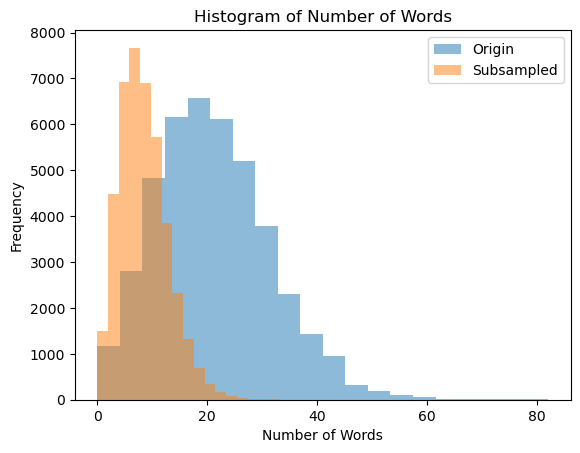

In [4]:
import matplotlib.pyplot as plt

sentences_lengths = [len(sentence) for sentence in sentences]
subsampled_lengths = [len(sentence) for sentence in subsampled]

plt.hist(sentences_lengths, bins=20, alpha=0.5, label='Origin')
plt.hist(subsampled_lengths, bins=20, alpha=0.5, label='Subsampled')

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words')
plt.legend()

plt.show()

In [5]:
def compare_counts(token):
    return (f'# of "{token}":'
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

print(compare_counts('the'))
print(compare_counts('join'))

# of "the":before=50770, after=2028
# of "join":before=45, after=45


In [6]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [6697, 4127, 3228, 1773, 4060], [993, 3922, 1922, 4743, 2696]]

In [2]:
def get_centers_and_contexts(corpus, max_window_size):
    """return center words and context words in skip-gram"""
    centers, contexts = [], []
    for line in corpus:
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [8]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [9]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pair: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pair: 1499489'

In [10]:
class RandomGenerator:
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [11]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 2, 2, 1, 1, 3, 1, 3, 1, 3]

In [12]:
def get_negatives(all_contexts, vocab, counter, K):
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for context in all_contexts:
        negatives = []
        while len(negatives) < len(context) * K:
            neg = generator.draw()
            if neg not in context:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [13]:
import torch
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), 
            torch.tensor(contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [14]:
x1 = (1, [2, 2], [3, 3, 3, 3])
x2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x1, x2))
names = ['centers', 'context_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
context_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [15]:
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives
    
    def __getitem__(self, index):
        return self.centers[index], self.contexts[index], self.negatives[index]
    
    def __len__(self):
        return len(self.centers)

def load_data_ptb(batch_size, max_window_size, num_noise_words, num_workers=2):
    sentences = read_ptb(directory_name)
    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, collate_fn=batchify, num_workers=num_workers)

    return data_iter, vocab

Put the code above into a separate file so that we can import it successfully in later notebook cells.
(Otherwise, we may encounter pickle related issues)

In [1]:
from dataset import load_data_ptb

names = ['centers', 'context_negatives', 'masks', 'labels']
data_iter, vocab = load_data_ptb(512, 5, 5, 5)

for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

Download and extraction complete.
centers shape: torch.Size([512, 1])
context_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [2]:
import math
import torch
from torch import nn

In [3]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [4]:
def skip_ngram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

skip_ngram(torch.ones((2, 1), dtype=torch.long), torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [5]:
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction='none'
        )
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [6]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [7]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.1102
1.8462


In [8]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size), 
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))


In [15]:
import matplotlib.pyplot as plt

def train(net, data_iter, lr, num_epochs, device='cuda'):
    def _init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(_init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    total_loss_history = []
    for epoch in range(num_epochs):
        total_loss, total_cnt = 0, 0
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_ngram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            total_loss += l.sum().item()
            total_cnt = l.numel()
        total_loss_history.append(total_loss / total_cnt)
        print(f'epoch: {epoch}, loss {total_loss / total_cnt}')

    line, = plt.plot(range(num_epochs), total_loss_history, label='loss')
    plt.legend(handles=[line], labels=['loss'])
    plt.show()
    plt.close()

epoch: 0, loss 2139.4817405799768
epoch: 1, loss 1893.1635703049697
epoch: 2, loss 1794.5951338929015
epoch: 3, loss 1689.6371935064142
epoch: 4, loss 1598.002035685948


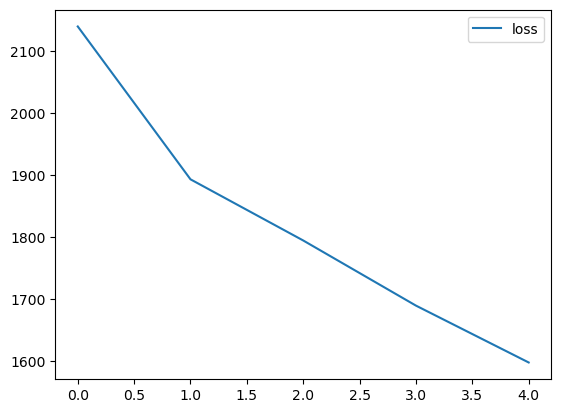

In [16]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [12]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.685: microprocessor
cosine sim=0.630: disk
cosine sim=0.609: chips
